## Master's thesis - Recurrent Neural Networks for Lagranigan Tracking of Microorganisms
#### Mathilda Gustafsson
#### 2025-05-29
#### This notebook is used to genrate data.

In [ ]:
# Load packages
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import importlib 

import logging
logging.getLogger('matplotlib.texmanager').setLevel(logging.WARNING)

Load dataset classes

In [ ]:
import definitions_of_classes
importlib.reload(definitions_of_classes)
from definitions_of_classes import datasetSequentialImages

Paramter settings

In [3]:
IMAGE_SIZE = 128

# properties of bacteria
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6

MIN_SIZE_ADDITIONAL = 0.5e-6 
MAX_SIZE_ADDITIONAL = 1.5e-6

MIN_INTENSITY_ADDITIONAL = 10
MAX_INTENSITY_ADDITIONAL = 90

# possible sizes in z led from the focal plane
MAX_Z_SIZE = 50 # max jump length is 5e-6, one pixel is 0.1e-6, so max pixel is 50

Generate data for tranining

In [ ]:
type_of_data = "identical bacteria"

if type_of_data == "identical bacteria":

    bacteria_centre = dt.Ellipse(
        intensity = 50,
        radius = (1e-6, 1e-6),
        position_unit = "pixel",
        position = np.array([IMAGE_SIZE/2, IMAGE_SIZE/2, 0]),
        rotation = 0,
        label = 1
    )

    bacteria_additional = dt.Ellipse(
        intensity = 50,
        radius = (1e-6, 1e-6),
        position_unit = "pixel",
        position = lambda: np.append(IMAGE_SIZE * np.random.uniform(0,1,2), np.array([0])),
        rotation = 0,
        velocity = lambda: np.append(np.random.uniform(-3,3,2), np.array([0])),
        label = 0
    )

elif type_of_data == "varying bacteria":
    
    bacteria_centre = dt.Ellipse(
        intensity = 50,
        radius = lambda : MIN_SIZE + (MAX_SIZE - MIN_SIZE) * np.random.rand(), 
        position_unit = "pixel",
        position = np.array([IMAGE_SIZE/2, IMAGE_SIZE/2, 0]),
        rotation = 0,
        label = 1
    )

    bacteria_additional = dt.Ellipse(
        intensity = lambda: MIN_INTENSITY_ADDITIONAL + (MAX_INTENSITY_ADDITIONAL - MIN_INTENSITY_ADDITIONAL) * np.random.rand(), 
        radius =  lambda : MIN_SIZE_ADDITIONAL + (MAX_SIZE_ADDITIONAL - MIN_SIZE_ADDITIONAL) * np.random.rand(),
        position_unit = "pixel",
        position = lambda: np.append(IMAGE_SIZE * np.random.uniform(0,1,2), np.random.uniform(-50,50)), 
        rotation = 0,
        velocity = lambda: np.append(np.random.uniform(-3,3,2), np.random.uniform(-5,5)), 
        label = 0
    )

# optical device
spherical_aberration = dt.SphericalAberration(coefficient = 0.5)
fluorescence_microscope = dt.Fluorescence( 
    NA = 0.8,
    wavelength = 680 * dt.units.nm,
    magnification = 10,
    resolution = 1 * dt.units.micrometer, # size per pixel, but with magnificaiton 10 we get 10 pixels per micrometer
    output_region = (0, 0, IMAGE_SIZE, IMAGE_SIZE),
    pupil = spherical_aberration
)


In [ ]:
def get_position_additional_particle(previous_value, velocity):

    new_position = previous_value + velocity

    if (new_position[0] < 0 or new_position[0] > IMAGE_SIZE or new_position[1] < 0 or new_position[1] > IMAGE_SIZE):
        new_side = np.random.randint(4)
        if new_side == 0:
            new_position[0] = 0
            new_position[1] = np.random.uniform(0, IMAGE_SIZE)
        elif new_side == 1:
            new_position[0] = IMAGE_SIZE
            new_position[1] = np.random.uniform(0, IMAGE_SIZE)
        elif new_side == 2:
            new_position[0] = np.random.uniform(0, IMAGE_SIZE)
            new_position[1] = 0
        else:
            new_position[0] = np.random.uniform(0, IMAGE_SIZE)
            new_position[1] = IMAGE_SIZE

    if ( np.abs(new_position[2]) > MAX_Z_SIZE ):
        new_position[2] -= new_position[2] / 8

    return new_position


if type_of_data == "identical bacteria":

    def get_position_center_particle(previous_value):

        new_position = previous_value + np.append(IMAGE_SIZE * 0.02 * np.random.uniform(-1,1,2), 0) 
        difference_from_centrum = new_position[0:2] - IMAGE_SIZE / 2
        if ( (np.abs(difference_from_centrum) > IMAGE_SIZE / 4).any() ) :
            new_position[0:2] -= difference_from_centrum / 4
        if (np.abs(new_position[2]) > MAX_Z_SIZE):
            new_position[2] -= new_position[2] / 8

        return new_position

    def get_velocity(previous_value):

        new_velocity = previous_value + np.append(np.random.uniform(-0.5,0.5,2), np.array([0])) 
        if (np.abs(new_velocity[0]) > 3):
            new_velocity[0] -= new_velocity[0] / 2
        if (np.abs(new_velocity[1]) > 3):
            new_velocity[1] -= new_velocity[1] / 2
        if (np.abs(new_velocity[2]) > 2):
            new_velocity[2] -= new_velocity[2] / 2
        
        return new_velocity


elif type_of_data == "varying bacteria":
    
    def get_position_center_particle(previous_value):

        new_position = previous_value + np.append(IMAGE_SIZE * 0.02 * np.random.uniform(-1,1,2), 3 * np.random.normal(0,1))
        difference_from_centrum = new_position[0:2] - IMAGE_SIZE / 2
        if ( (np.abs(difference_from_centrum) > IMAGE_SIZE / 4).any() ) :
            new_position[0:2] -= difference_from_centrum / 4
        if (np.abs(new_position[2]) > MAX_Z_SIZE):
            new_position[2] -= new_position[2] / 8

        return new_position

    def get_velocity(previous_value):

        new_velocity = previous_value + np.append(np.random.uniform(-0.5,0.5,2), np.random.uniform(-1,1)) 
        if (np.abs(new_velocity[0]) > 3):
            new_velocity[0] -= new_velocity[0] / 2
        if (np.abs(new_velocity[1]) > 3):
            new_velocity[1] -= new_velocity[1] / 2
        if (np.abs(new_velocity[2]) > 2):
            new_velocity[2] -= new_velocity[2] / 2
        
        return new_velocity


In [8]:
images_per_sequence = 300
NUM_ADDITIONAL_PARTICLES = 2

def get_positions_as_targets(image):

    positions = np.zeros((NUM_ADDITIONAL_PARTICLES + 1, 4))
    i = 0

    for property in image.properties:
        if "position" in property:
            positions[i,0:3] = property["position"] / [IMAGE_SIZE, IMAGE_SIZE, MAX_Z_SIZE]
            positions[i, 3] = property["label"]
            i += 1

    if i < (NUM_ADDITIONAL_PARTICLES + 1):
        positions = positions[:i,:]

    return positions

# create sequential objects from the spheres
bacteria_centre_moving = dt.Sequential(bacteria_centre, position = get_position_center_particle) 
bacteria_additional_moving = dt.Sequential(bacteria_additional, position = get_position_additional_particle)
bacteria_additional_moving = dt.Sequential(bacteria_additional_moving, velocity = get_velocity)

all_bacteria = bacteria_centre_moving & (bacteria_additional_moving ^ (lambda : np.random.randint(1, NUM_ADDITIONAL_PARTICLES + 1)))

# image the bacteria using optics
imaged_moving_bacteria = fluorescence_microscope(all_bacteria) 
imaged_moving_bacteria_ready_for_pipeline = imaged_moving_bacteria >> dt.MoveAxis(2,0) >> dt.NormalizeMinMax() >> dt.pytorch.ToTensor(dtype=torch.float)

# store propoerties of the image
imaged_moving_bacteria.store_properties()

# create a sequence
pipeline_spherical_bacteria = dt.Sequence( imaged_moving_bacteria_ready_for_pipeline  & (imaged_moving_bacteria >> get_positions_as_targets >> dt.pytorch.ToTensor(dtype = torch.float)), sequence_length = images_per_sequence)
pipeline_updated = pipeline_spherical_bacteria.update()

In [ ]:
# Create a sequence for visualization only
seq_for_plot = fluorescence_microscope(all_bacteria) >> dt.MoveAxis(1,0)
sequence_visualization = dt.Sequence(seq_for_plot, sequence_length = 300)
sequence_visualization.update().plot(cmap = 'gray', origin = "lower")

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Create datasets

In [ ]:
training_set_length = 300
validation_set_length = 100
test_set_length = 100

dataset_training = datasetSequentialImages(pipeline_spherical_bacteria, training_set_length)
dataset_validation = datasetSequentialImages(pipeline_spherical_bacteria, validation_set_length)
dataset_test = datasetSequentialImages(pipeline_spherical_bacteria, test_set_length)

#torch.save(dataset_training, './Data/dataTrain.pt')
#torch.save(dataset_validation, './Data/dataValidation.pt')
#torch.save(dataset_test, './Data/dataTest.pt')

## Create datasets for overlap analysis and feature importance analysis

In [ ]:
type_of_data = "identical bacteria" 

if type_of_data == "identical bacteria":

    bacteria_centre = dt.Ellipse(
        intensity = 50,
        radius = (1e-6, 1e-6),
        position_unit = "pixel",
        position = np.append([IMAGE_SIZE/3, IMAGE_SIZE/2], 0),
        rotation = 0,
        label = 1
    )

    bacteria_additional = dt.Ellipse(
        intensity = 50,
        radius = (1e-6, 1e-6),
        position_unit = "pixel",
        position = np.array([IMAGE_SIZE * 2/3, IMAGE_SIZE, 0]),
        rotation = 0,
        velocity = np.array([0, -2, 0]),
        label = 0
    )

elif type_of_data == "varying bacteria":

    bacteria_centre = dt.Ellipse(
        intensity = 50,
        radius = lambda : MIN_SIZE + (MAX_SIZE - MIN_SIZE) * np.random.rand(),
        position_unit = "pixel",
        position = np.append([IMAGE_SIZE/3, IMAGE_SIZE/2],0),
        rotation = 0,
        label = 1
    )

    bacteria_additional = dt.Ellipse(
        intensity = lambda: MIN_INTENSITY_ADDITIONAL + (MAX_INTENSITY_ADDITIONAL - MIN_INTENSITY_ADDITIONAL) * np.random.rand(), 
        radius =  lambda : MIN_SIZE_ADDITIONAL + (MAX_SIZE_ADDITIONAL - MIN_SIZE_ADDITIONAL) * np.random.rand(), 
        position_unit = "pixel",
        position = np.array([IMAGE_SIZE * 2/3, IMAGE_SIZE, 0]),
        rotation = 0,
        velocity = np.array([0, -2, 0]),
        label = 0
    )

# optical device
spherical_aberration = dt.SphericalAberration(coefficient = 0.5)
fluorescence_microscope = dt.Fluorescence( 
    NA = 0.8,
    wavelength = 680 * dt.units.nm,
    magnification = 10,
    resolution = 1 * dt.units.micrometer,
    output_region = (0, 0, IMAGE_SIZE, IMAGE_SIZE),
    pupil = spherical_aberration
)


In [ ]:
def get_position_additional_particle(previous_value, velocity):

    new_position = previous_value + velocity

    if (new_position[0] < IMAGE_SIZE/4):
        new_position[0] += IMAGE_SIZE/20
    elif (new_position[0] > 3/4 * IMAGE_SIZE):
        new_position[0] -= IMAGE_SIZE/20


    if (new_position[0] < 0 or new_position[0] > IMAGE_SIZE or new_position[1] < 0 or new_position[1] > IMAGE_SIZE):
        new_side = np.random.randint(4)
        if new_side == 0:
            new_position[0] = 0
            new_position[1] = np.random.uniform(0, IMAGE_SIZE)
        elif new_side == 1:
            new_position[0] = IMAGE_SIZE
            new_position[1] = np.random.uniform(0, IMAGE_SIZE)
        elif new_side == 2:
            new_position[0] = np.random.uniform(0, IMAGE_SIZE)
            new_position[1] = 0
        else:
            new_position[0] = np.random.uniform(0, IMAGE_SIZE)
            new_position[1] = IMAGE_SIZE

    if ( np.abs(new_position[2]) > MAX_Z_SIZE ):
        new_position[2] -= new_position[2] / 8

    return new_position


if type_of_data == "identical bacteria":

    def get_position_center_particle(previous_value): # for a spherical particle

        new_position = previous_value + np.append(IMAGE_SIZE * 0.02 * np.random.uniform(-1,1,2), 0)
        difference_from_centrum = new_position[0:2] - IMAGE_SIZE / 2

        if ( (np.abs(difference_from_centrum) > IMAGE_SIZE / 4).any() ) :
            new_position[0:2] -= difference_from_centrum / 4

        if (np.abs(new_position[2]) > MAX_Z_SIZE):
            new_position[2] -= new_position[2] / 8

        return new_position

    def get_velocity(previous_value):

        new_velocity = previous_value + np.array([np.random.uniform(-1,1) * IMAGE_SIZE *0.03, 0, 0])

        if (np.abs(new_velocity[0]) > 3):
            new_velocity[0] -=  new_velocity[0] / 2
        if (np.abs(new_velocity[2]) > 2):
            new_velocity[2] -= new_velocity[2] / 2

        return new_velocity
    

elif type_of_data == "varying bacteria":

    def get_position_center_particle(previous_value): 

        new_position = previous_value + np.append(IMAGE_SIZE * 0.02 * np.random.uniform(-1,1,2), 3 * np.random.normal(0,1))
        difference_from_centrum = new_position[0:2] - IMAGE_SIZE / 2

        if ( (np.abs(difference_from_centrum) > IMAGE_SIZE / 4).any() ) :
            new_position[0:2] -= difference_from_centrum / 4

        if (np.abs(new_position[2]) > MAX_Z_SIZE):
            new_position[2] -= new_position[2] / 8

        return new_position

    def get_velocity(previous_value):

        new_velocity = previous_value + np.array([np.random.uniform(-1,1) * IMAGE_SIZE *0.03, 0, np.random.uniform(-1,1)])

        if (np.abs(new_velocity[0]) > 3):
            new_velocity[0] -=  new_velocity[0] / 2
        if (np.abs(new_velocity[2]) > 2):
            new_velocity[2] -= new_velocity[2] / 2

        return new_velocity
    

In [13]:
images_per_sequence = 65
NUM_ADDITIONAL_PARTICLES = 1

def get_positions_as_targets(image):

    positions = np.zeros((NUM_ADDITIONAL_PARTICLES + 1, 4))
    i = 0

    for property in image.properties:
        if "position" in property:
            positions[i,0:3] = property["position"] / [IMAGE_SIZE, IMAGE_SIZE, MAX_Z_SIZE]
            positions[i, 3] = property["label"]
            i += 1

    if i < (NUM_ADDITIONAL_PARTICLES + 1):
        positions = positions[:i,:]

    return positions

bacteria_centre_moving = dt.Sequential(bacteria_centre, position = get_position_center_particle) 
bacteria_additional_moving = dt.Sequential(bacteria_additional, position = get_position_additional_particle)
bacteria_additional_moving = dt.Sequential(bacteria_additional_moving, velocity = get_velocity)

all_bacteria = bacteria_centre_moving & (bacteria_additional_moving ^ NUM_ADDITIONAL_PARTICLES)

imaged_moving_bacteria = fluorescence_microscope(all_bacteria) >> dt.FlipUD(p = 0.5) >> dt.FlipLR(p = 0.5) >> dt.FlipDiagonal(p = 0.5) # do flips here bc properties are stored on image_moving_bacteria. If flips placed on row below the positions will be incorrect.
imaged_moving_bacteria_ready_for_pipeline = imaged_moving_bacteria >> dt.MoveAxis(2,0) >> dt.NormalizeMinMax() >> dt.pytorch.ToTensor(dtype=torch.float) 

# get position of bacteria
imaged_moving_bacteria.store_properties()

# create a sequence
pipeline_spherical_bacteria = dt.Sequence(imaged_moving_bacteria_ready_for_pipeline & (imaged_moving_bacteria >> get_positions_as_targets >> dt.pytorch.ToTensor(dtype = torch.float)), sequence_length = images_per_sequence)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


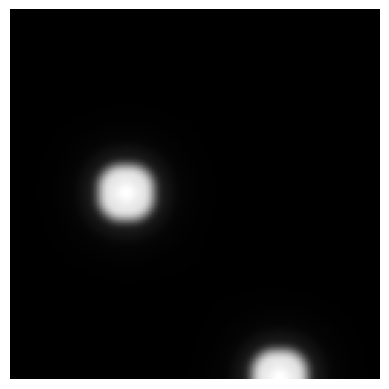

In [14]:
# Create a sequence for visualization only
seq_for_plot = fluorescence_microscope(all_bacteria) >> dt.MoveAxis(1,0)
sequence_visualization = dt.Sequence(seq_for_plot, sequence_length = 65)
sequence_visualization.update().plot(cmap = 'gray', origin = "lower")

Create dataset

In [ ]:
# set seed to create sequences with same movement (note that the same functions (z0 or zvar must be used))
#np.random.seed(2022)
#import random 
#random.seed(2022)

test_set_length = 500
dataset_test_collisions = datasetSequentialImages(pipeline_spherical_bacteria, test_set_length)

#torch.save(dataset_test_collisions, './overlapping_bacteria.pt')